<a href="https://colab.research.google.com/github/Meddebma/pyradiomics/blob/master/Projekt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Setup environment**

In [11]:
%pip install -q "monai-weekly[itk, pillow]"

**Setup imports**

In [12]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import logging
import os
import sys
import tempfile
import shutil

import matplotlib.pyplot as plt
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np

import monai
from monai.networks.nets import DenseNet121, Classifier
from monai.apps import download_and_extract
from monai.config import print_config
from monai.utils import first
from monai.data import CacheDataset, DataLoader, ImageDataset, ITKReader, PILReader, Dataset
from torch.utils.data import DataLoader 
from monai.transforms import Transform
from monai.transforms import (
    AddChannel,
    Compose,
    LoadImage,
    RandRotate90,
    Resize,
    Orientation,
    ScaleIntensity,
    ToTensor,
    Randomizable,
    LoadImaged,
    ToTensord,
)
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pandas as pd
import seaborn as sns 
from glob import glob
import logging
from abc import ABC, abstractmethod
from typing import Any, Callable, Dict, Generator, Hashable, Iterable, List, Optional, Tuple

import numpy as np
import torch

import numpy as np
from monai.transforms import Transform, AddChannel, AsChannelFirst


logging.basicConfig(stream=sys.stdout, level=logging.INFO)
print_config()

MONAI version: 0.6.dev2121
Numpy version: 1.19.5
Pytorch version: 1.8.1+cu101
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: ffba47d55439eb803b94d12ea75f460875c5af95

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.16.2
Pillow version: 7.1.2
Tensorboard version: 2.5.0
gdown version: 3.6.4
TorchVision version: 0.9.1+cu101
ITK version: 5.1.2
tqdm version: 4.41.1
lmdb version: 0.99
psutil version: 5.4.8

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



**Data Direction**

In [13]:
data_dir= "/content/drive/My Drive/Task09_Spleen"

In [14]:
labels_all = pd.read_excel (r'/content/drive/MyDrive/Task09_Spleen/labels.xlsx')


In [15]:
images = sorted(glob(os.path.join(data_dir, "Projekt2t", "*.nii.gz")))
#labels= labels_all["label"]
labels= np.array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1], dtype=np.int64)



In [16]:
labels

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

In [17]:
class ChannelFirstOrAdd(Transform):
    def __init__(self):
        self.channel_first = AsChannelFirst()
        self.add_channel = AddChannel()

    def __call__(self, im):
        ndims = im.ndim
        if ndims == 4:
            return self.channel_first(im)
        elif ndims == 3:
            return self.add_channel(im)
        else:
            raise RuntimeError

t = ChannelFirstOrAdd()
already_has_channel = np.zeros((3, 4, 5, 2))
print(t(already_has_channel).shape)

needs_channel_added = np.zeros((3, 4, 5))
print(t(needs_channel_added).shape)

train_transforms = Compose([ScaleIntensity(), ChannelFirstOrAdd(), Resize((96, 96, 96),mode="nearest"), ToTensor()])
val_transforms = Compose([ScaleIntensity(), ChannelFirstOrAdd(), Resize((96, 96, 96),mode="nearest"), ToTensor()])

    # Define image dataset, data loader
check_ds = ImageDataset(image_files=images, labels=labels, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=2, num_workers=2)
im, label = monai.utils.misc.first(check_loader)
print(type(im), im.shape, label)
print(len(im.shape))


(2, 3, 4, 5)
(1, 3, 4, 5)
<class 'torch.Tensor'> torch.Size([2, 1, 96, 96, 96]) tensor([1, 1])
5


In [18]:
train_ds = ImageDataset(image_files=images[:12], labels=labels[:12], transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2)

# create a validation data loader
val_ds = ImageDataset(image_files=images[-12:], labels=labels[-12:], transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=2, num_workers=2)

# Create DenseNet121, CrossEntropyLoss and Adam optimizer
device = torch.device("cuda")
model = monai.networks.nets.DenseNet121(spatial_dims=3, in_channels=1, out_channels=2).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)

In [19]:
# start a typical PyTorch training
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()
max_epochs = 5
for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            num_correct = 0.0
            metric_count = 0
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(
                    device), val_data[1].to(device)
                val_outputs = model(val_images)
                value = torch.eq(val_outputs.argmax(dim=1), val_labels)
                metric_count += len(value)
                num_correct += value.sum().item()
            metric = num_correct / metric_count
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(),
                           "best_metric_model_classification3d_array.pth")
                print("saved new best metric model")
            print(
                "current epoch: {} current accuracy: {:.4f} "
                "best accuracy: {:.4f} at epoch {}".format(
                    epoch + 1, metric, best_metric, best_metric_epoch
                )
            )
            writer.add_scalar("val_accuracy", metric, epoch + 1)
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/5
1/6, train_loss: 0.7042
2/6, train_loss: 0.5178


Modifying image pixdim from [0.78125 0.78125 5.      1.     ] to [  0.78125     0.78125     5.        394.4946134]
Modifying image pixdim from [0.728516 0.728516 5.       1.      ] to [  0.72851598   0.72851598   5.         358.76446171]


3/6, train_loss: 0.6970


RuntimeError: ignored

In [ ]:
test_ds = ImageDataset(
    image_files=images, labels=labels, transform=val_transforms)
test_loader = DataLoader(val_ds, batch_size=1, num_workers=2)
itera = iter(test_loader)


def get_next_im():
    test_data = next(itera)
    return test_data[0].to(device), test_data[1].unsqueeze(0).to(device)


def plot_occlusion_heatmap(im, heatmap):
    plt.subplots(1, 2)
    plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(im.cpu()))
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.imshow(heatmap)
    plt.colorbar()
    plt.show()

Computing occlusion sensitivity: 100%|██████████| 64/64 [00:00<00:00, 77.12it/s]


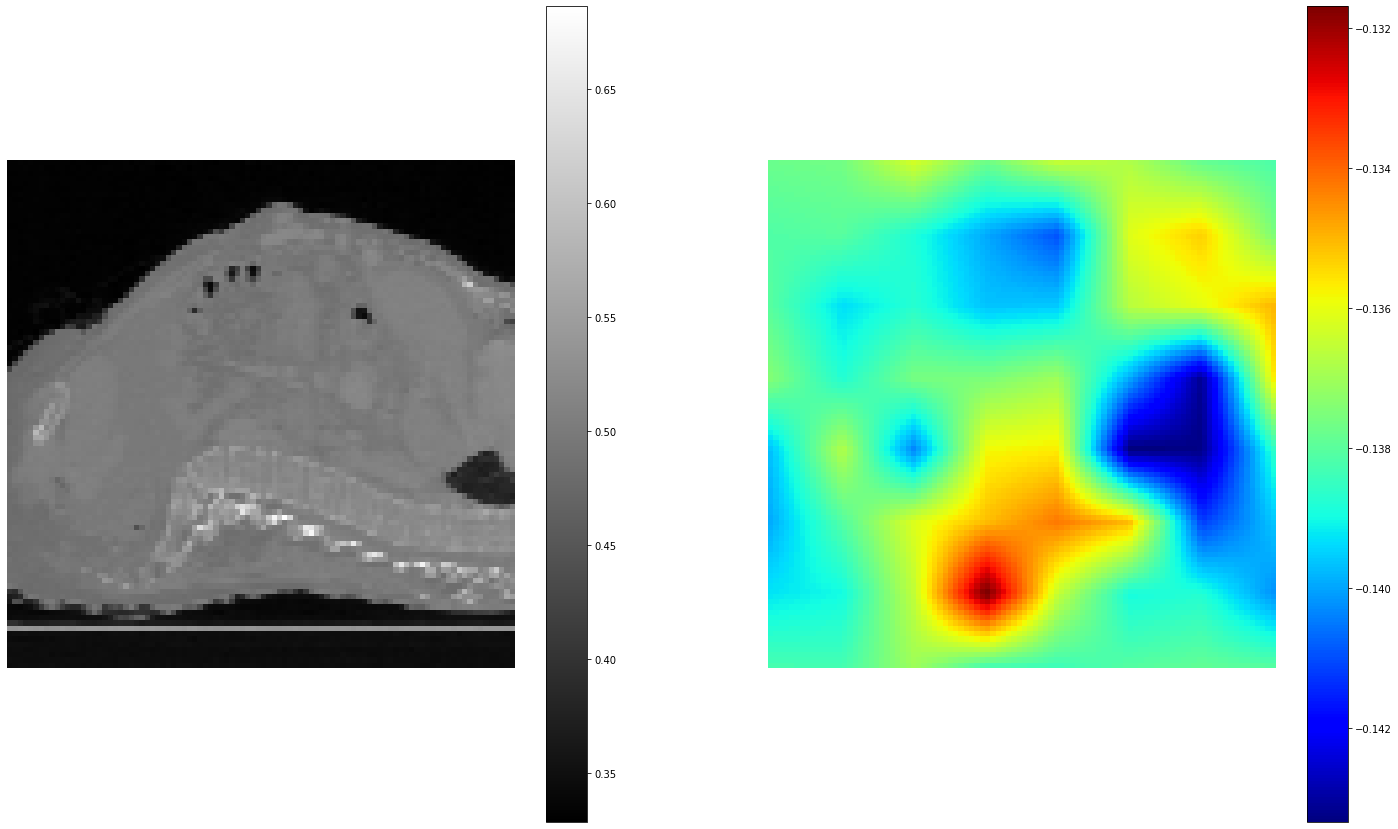

In [ ]:
# Get a random image and its corresponding label
img, label = get_next_im()

# Get the occlusion sensitivity map
occ_sens = monai.visualize.OcclusionSensitivity(
    nn_module=model, mask_size=12, n_batch=10, stride=12)
# Only get a single slice to save time.
# For the other dimensions (channel, width, height), use
# -1 to use 0 and img.shape[x]-1 for min and max, respectively
depth_slice = img.shape[2] // 2
occ_sens_b_box = [-1, -1, depth_slice, depth_slice, -1, -1, -1, -1]

occ_result, _ = occ_sens(x=img, b_box=occ_sens_b_box)
occ_result = occ_result[..., label.item()]

fig, axes = plt.subplots(1, 2, figsize=(25, 15), facecolor='white')

for i, im in enumerate([img[:, :, depth_slice, ...], occ_result]):
    cmap = 'gray' if i == 0 else 'jet'
    ax = axes[i]
    im_show = ax.imshow(np.squeeze(im[0][0].detach().cpu()), cmap=cmap)
    ax.axis('off')
    fig.colorbar(im_show, ax=ax)